# Abstract

In this project, we use Cricket Test match data from [cricsheet](https://cricsheet.org/) to evaluate the performance of national cricket teams. We use multiple approaches to assess a team's performance and state each approach's merits and demerits. We start with a frequentist approach followed by a 1-parameter logistic (1pl) Rasch model followed by a 2-parametric logistic (2pl) Rasch model. In each section, we will evaluate the results of the models and discuss them. In the last section, we will compare results between different models. The code is provided at the end so that the results can be recreated. 

*Note: to recreate the results in this notebook, please run the "code" section at the end before running the other sections. This is because variables are being populated in that section.*


# Introduction  

The dataset for cricket is stored in JSON format where each JSON contains ball-by-ball data for each test match. We parse the json iteratively and store the results in tabular format.
The finalized data frame contains:
* `Team_x`: The first team in the matchup.  
* `Team_y`: The second team in the matchup, i.e. the opposition.  
* `num_matchup`: Total number of matchups.  
* `wins`: number of wins by `Team_x`.  
* `losses`: number of losses by `Team_y`.
* `draws`: the number of draws by `Team_x` and `Team_y`.  

Here is a subset of the data:

In [27]:
# to populate First run code cells in the "code section"
# sample data
cross_join_df2[['Team_x',	'Team_y',	'num_matchups', 'wins', 'losses', 'draws']].head(19)

,Team_x,Team_y,num_matchups,wins,losses,draws
1,Australia,Bangladesh,4,3,0,0
2,Australia,England,52,27,0,9
3,Australia,India,44,13,0,12
5,Australia,New Zealand,20,17,0,2
6,Australia,Pakistan,21,14,0,3
7,Australia,South Africa,29,15,0,3
8,Australia,Sri Lanka,16,10,0,2
9,Australia,West Indies,20,14,0,4
10,Australia,Zimbabwe,2,2,0,0
11,Bangladesh,Australia,4,1,0,0


## Frequentist Estimate

In [28]:
summary_frequentist.sort_values('freqentist_z_score',ascending=False)

,index,Team_x,num_matchups,wins,losses,draws,win_pct,freqentist_z_score,std_dev
0,0,Australia,208,115,0,35,55.3,1.337819,0.497183
7,7,South Africa,181,90,0,31,49.7,0.982452,0.499991
3,3,India,204,100,0,51,49.0,0.938031,0.499900
2,2,England,254,112,0,53,44.1,0.627085,0.496507
5,5,New Zealand,157,62,0,32,39.5,0.335176,0.488851
8,8,Sri Lanka,168,66,0,36,39.3,0.322484,0.488417
6,6,Pakistan,151,54,0,31,35.8,0.100380,0.479412
9,9,West Indies,158,36,0,38,22.8,-0.724580,0.419543
1,1,Bangladesh,113,19,0,14,16.8,-1.105330,0.373866
4,4,Ireland,7,1,0,0,14.3,-1.263976,0.350073


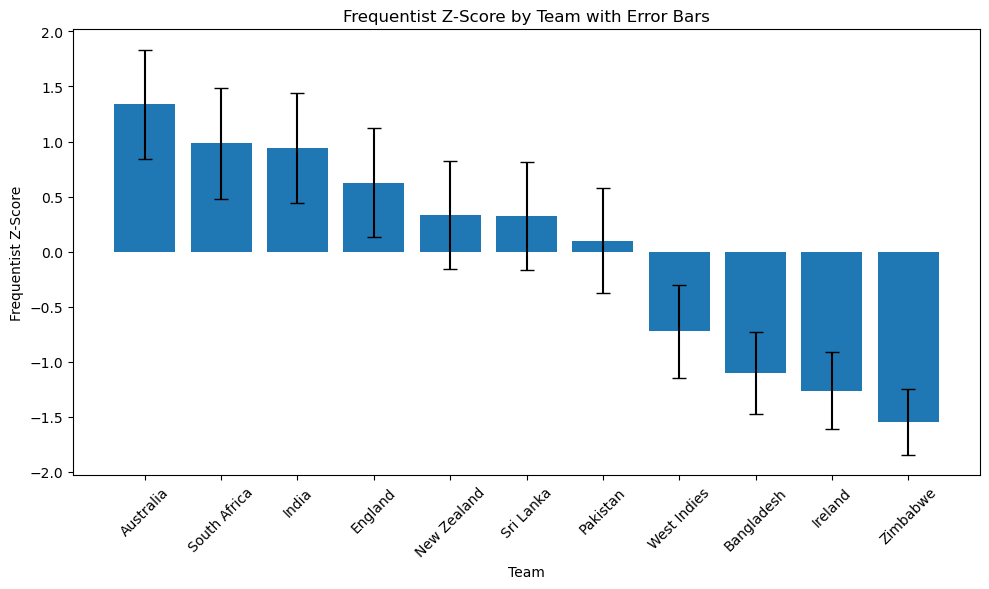

In [29]:
frequentist_summary_chart

The table above shows results if we employ a frequentist approach. We can see that the team's ability can be ranked in the order above, with Australia being the top team and Zimbabwe being the worst team. The error bars are the standard error associated with each value.

## Bayesian 1pl Rasch model  
Next we use a Bayesian approach to model the same data. We use a rash 1 parameter logistic (1pl) model which uses ability and difficulty parameter to model outcomes where the probabilty of outcome is defined as:  
$$ Pr(out=1) = \frac{\exp(\alpha_i - \beta_j + \delta)}{1 + \exp(\alpha_i - \beta_j + \delta)} $$

The ability parameter measures a subject's proficiency or skill level.
The difficulty parameter indicates how challenging a test item is. More difficult items require a higher ability to achieve a favorable outcome.
This model uses the logit-parameterized Bernoulli distribution

Our approach is adapted from the Item Response Models Section of the [MC-stan guide](https://mc-stan.org/docs/2_20/stan-users-guide/item-response-models-section.html) and our model is specified as follows:

$$ \text{delta} \quad or \quad \delta \sim N(0.75,1) $$
$$ \text{ability}_i \quad or \quad \alpha_i \sim \text{Normal}(0, 1) \quad \text{for} \; i = 1, \ldots, N_{\text{teams}}  $$
$$  \text{difficulty}_j \quad or \quad \beta_j \sim \text{Normal}(0, 1) \quad \text{for} \; j = 1, \ldots, N_{\text{difficulty}}$$

$$ \text{logit}_p = \alpha_i - \beta_j + \delta $$

$$  \text{out}_n \sim \text{Binomial}(N, \text{logit}_p) $$

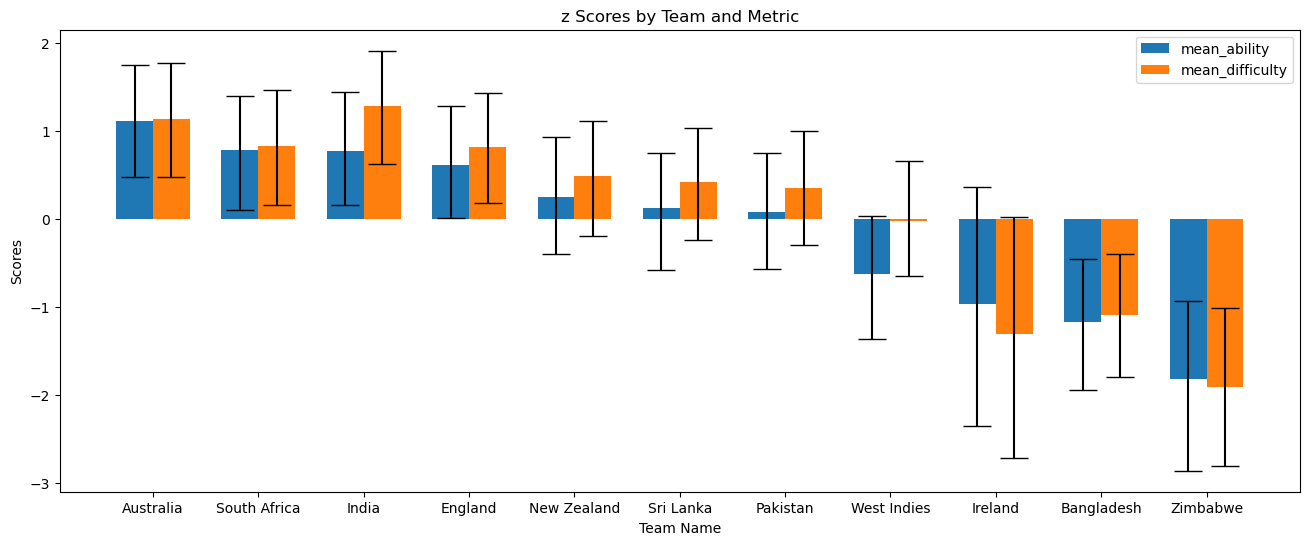

In [30]:
difficulty_ability_plot_1pl

Ability and difficulty are closely related, but they are not perfectly correlated. For example, India is the most difficult team, but in terms of ability, they rank third. For the top and bottom performers, our 95% HPD credible sets do not contain 0, indicating a high level of certainty that these teams are either underperforming or overperforming. However, for teams in the middle, the HPD interval contains 0, so it is unclear if these teams are above or below average.

Additionally, we can compare the HPD intervals for all the teams to understand how they stack up against one another. For instance, the HPD intervals for the West Indies and Australia do not overlap, indicating a high level of certainty that Australia is a better team than the West Indies. Conversely, the HPD intervals for Pakistan and Sri Lanka overlap significantly, leading to a high degree of uncertainty about which team is better, despite Sri Lanka having a higher mean ability.

The rasch model offers a robust framework for measuring latent traits such as ability and item difficulty. It ensures that comparison of subjects is independent of the specific sample and test items used. However, the Rasch model's assumptions—such as unidimensionality and equal item discrimination—can be limiting. These assumptions may not hold in real-world scenarios where multiple traits influence responses and items vary in their ability to discriminate between different levels of ability. To cater to this limitation we introduce the 2 parameter logistic.

## Bayesian 2pl Rash Model
The Rasch 2-parameter logistic model (2PL) improves upon the 1-parameter logistic model (1PL) by introducing an additional parameter to account for item discrimination. This enhancement addresses one of the primary limitations of the 1PL model by allowing for varying item discrimination.

We add to a 1pl model by adding hierarchy and a discrimination term.
The probability of an outcome is modeled by:

$$ Pr(out=1) = \frac{\exp(\gamma_j * (\alpha_i - (\beta_j+\delta)))}{1 + \exp(\gamma_j * (\alpha_i - (\beta_j + \delta)))} $$

The discrimination terms are:
$$ \text{standard\ deviation\ of\ discrimination} \quad or \quad \sigma_{\gamma} \sim \text{HalfCauchy}(0, 3) $$
$$ \text{discrimination} \quad or \quad \gamma_j \sim LogNormal(0,\sigma_\gamma)$$

We define the following distribution to model a team's ability:
$$ \text{ability} \quad or \quad \alpha \sim Normal(0,1)$$

To model Opponent Difficulty we define the following distributions:  
We recenter difficulty in avoiding fit issues:
<!-- $$ \text{mean\ of\ difficulty} \quad or \quad \mu_{\beta} \sim \text{studentT}(3,0,5) $$ -->
$$ \text{mean\ question\ difficulty} \quad or \quad \delta \sim \text{Cauchy}(0,5)$$
$$ \text{standard\ deviation\ of\ difficulty} \quad or \quad \sigma_{\beta} \sim \text{HalfCauchy}(0,5) $$
$$ \text{difficulty} \quad or \quad \beta \sim Normal(0,\sigma_{\beta})$$

The outcome is defined as:
$$ \text{logit}_p = \gamma_j * (\alpha_i - (\beta_j + \delta)) $$
$$  \text{out}_n \sim \text{Binomial}(N, \text{logit}_p) $$


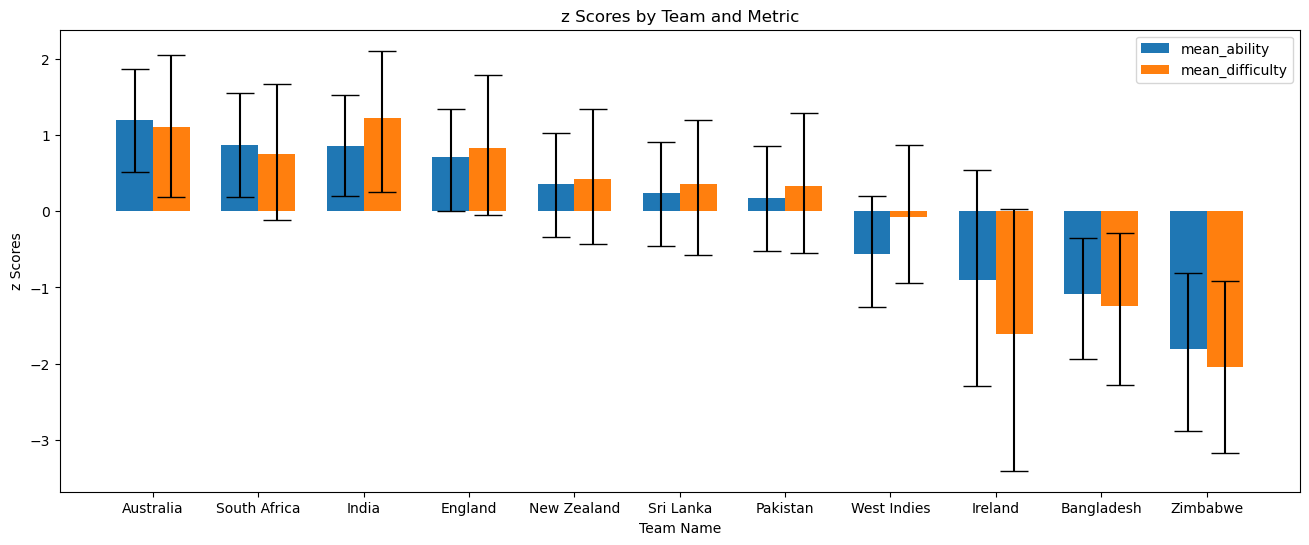

In [31]:
difficulty_ability_plot_2pl

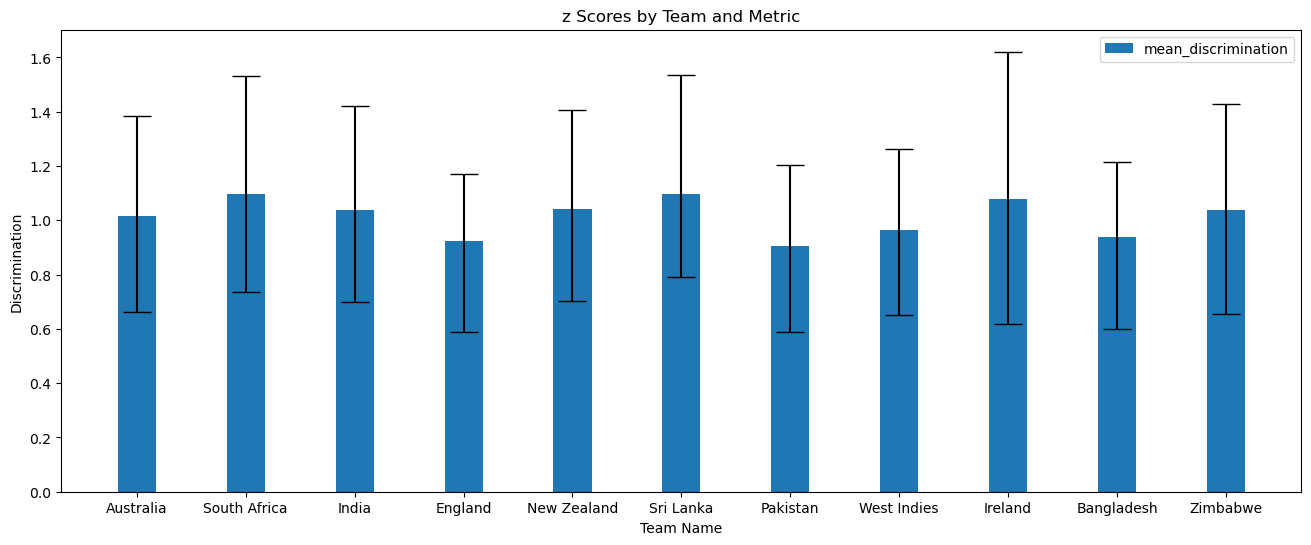

In [32]:
discrimination_2pl

Our estimates of ability and difficulty are similar to what we get in our 1PL model. However, our 2PL model gives us extra information with the discrimination parameter. It indicates how well an item can differentiate between individuals who have different levels of the underlying trait or ability being measured. A higher discrimination parameter means that the item is better at distinguishing between individuals with slightly different ability levels. This means items with higher discrimination are more sensitive to differences in ability. From the plot above Sri Lanka can have the highest discrimination, however, the HPD around all the values is very wide, which means we cannot say for certain if one team's ability to discriminate is higher than another team's.

## Compare Models 

### Estimates of the ability 
In this section we compare our frequestist estimates with the estimates from the 1pl model and the estimates from the 2pl model.

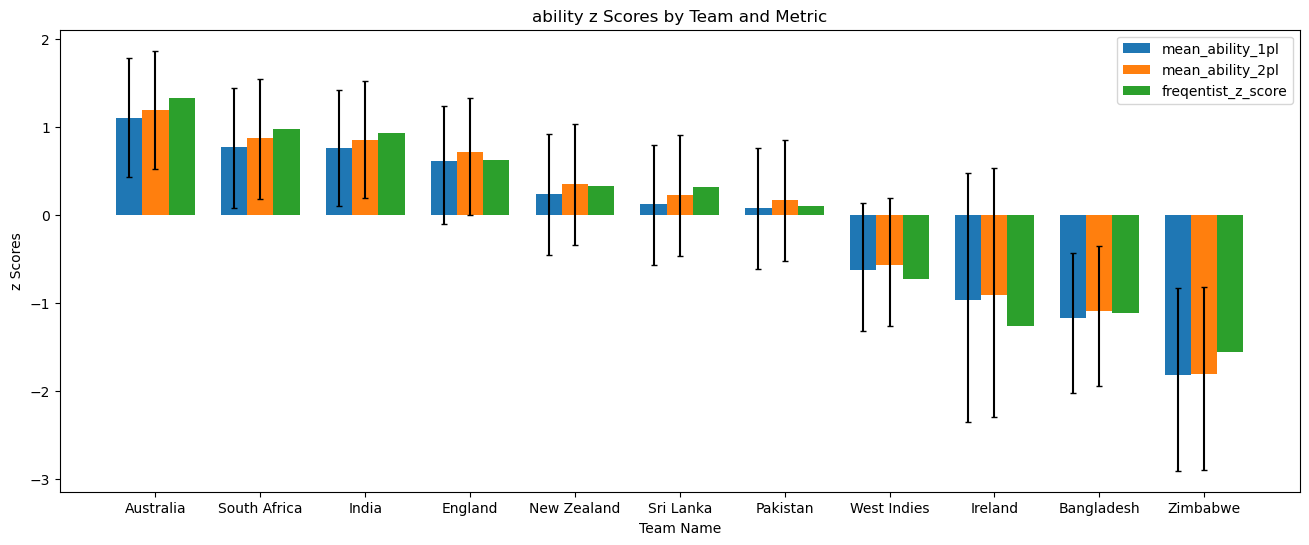

In [33]:
ability_measured_by_each_model

In the above plot, we can see that all 3 methods of estimating ability (win percentage, bayesian 1pl model, and Bayesian 2pl model) give similar means. However, the Bayesian models do a good job of quantifying the uncertainty around the means. Comparing the 1pl with the 2pl model we don't see any major changes however, we do see that the 2pl usually predicts a slightly higher z_score for each team.

### Estimate of Difficulty 
In this section, we compare the estimates for difficulty from the 1pl model with the estimates for difficulty from the 2pl model.

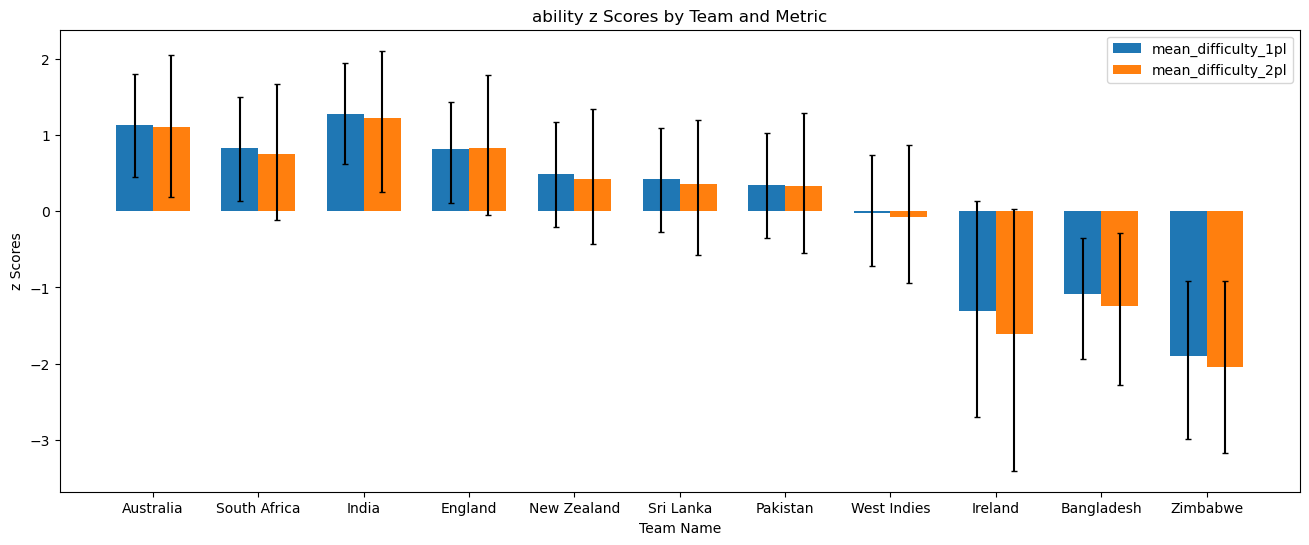

In [34]:
difficulty_measured_by_each_model

Similar results are seen for both 1pl and 2pl models, however, the 95% credible interval for the 2pl is wider indicating lower confidence in our means. Secondly, even though Australia's team has a higher ability, India seems to be the most difficult team to beat and Zimbabwe seems to be the easier team to beat.

# Conclusion

Based on the results we see that we achieve similar results when using mean values versus when we use a 1-parameter logistic model versus when we use a 2-parameter logistic model. However, the Bayesian models do a good job of quantifying the uncertainty around the means. Moreover, we can get some other informative information from our parameters which can give us information about the difficulty of the opponent or the descriminative power of the opponent. Our results indicate that although Australia has the highest ability, the Indian team is the hardest to beat and that the Sri Lankan team has the highest ability to discriminate between different subjects.

For further exploration, we can explore improvements on our 2pl model by exploring the parameter space further and also explore 3-parameter logistic models. 

# Code

## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import os, sys
import json
import re
import matplotlib.pyplot as plt

In [2]:
# Define a function to extract the digit(s) from arviz output
def extract_digit(text):
    match = re.search(r'\[(\d+)\]', text)
    return match.group(1) if match else None

In [3]:
all_teams = ['Australia', 'Bangladesh', 'England', 'India', 'Ireland', 'New Zealand', 'Pakistan', 'South Africa', 'Sri Lanka', 
             'West Indies', 'Zimbabwe']
df = pd.DataFrame({'Team': all_teams}) 
cross_join_df = df.merge(df, how='cross')
cross_join_df['num_matchups']=0
cross_join_df['wins']=0
cross_join_df['losses']=0
cross_join_df['draws']=0

## Parse JSON Files

In [4]:
files_list = (os.listdir('tests_male_json'))
files_list.remove('README.txt')
for file_name in files_list:
    with open('tests_male_json/'+file_name, 'r') as file:
        data = json.load(file)
        outcome = (data['info']['outcome'])
        teams = data['info']['teams']
        cross_join_df.loc[(cross_join_df['Team_y']==teams[0]) & (cross_join_df['Team_x']==teams[1]),'num_matchups'] +=1
        cross_join_df.loc[(cross_join_df['Team_x']==teams[0]) & (cross_join_df['Team_y']==teams[1]),'num_matchups'] +=1
        if 'winner' in outcome.keys():
            cross_join_df.loc[cross_join_df.Team_x.isin(teams) &
                          cross_join_df.Team_y.isin(teams) &
                  (cross_join_df.Team_y != cross_join_df.Team_x) &
                  cross_join_df.Team_x.isin([outcome['winner']])
                  ,'wins']+=1
        else:
            cross_join_df.loc[cross_join_df.Team_x.isin(teams) &
                          cross_join_df.Team_y.isin(teams) &
                  (cross_join_df.Team_y != cross_join_df.Team_x),'draws'] += 1

## Preprocess Dataframe

In [5]:
cross_join_df2 = cross_join_df[cross_join_df['num_matchups']!=0]

cross_join_df2['Team_x_factor'], unique_teams = pd.factorize(cross_join_df2['Team_x'])

# Create a mapping dictionary from unique_teams
team_mapping = {team: idx for idx, team in enumerate(unique_teams)}
reversed_dict = {str(v): k for k, v in team_mapping.items()}

# Apply the same mapping to Team_y
cross_join_df2['Team_y_factor'] = cross_join_df2['Team_y'].map(team_mapping)
teams = cross_join_df2['Team_x'].unique()

pd.set_option('display.max_rows', None)
cross_join_df2.head(20) 

/tmp/ipykernel_50653/1736895967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_join_df2['Team_x_factor'], unique_teams = pd.factorize(cross_join_df2['Team_x'])
/tmp/ipykernel_50653/1736895967.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_join_df2['Team_y_factor'] = cross_join_df2['Team_y'].map(team_mapping)


,Team_x,Team_y,num_matchups,wins,losses,draws,Team_x_factor,Team_y_factor
1,Australia,Bangladesh,4,3,0,0,0,1
2,Australia,England,52,27,0,9,0,2
3,Australia,India,44,13,0,12,0,3
5,Australia,New Zealand,20,17,0,2,0,5
6,Australia,Pakistan,21,14,0,3,0,6
7,Australia,South Africa,29,15,0,3,0,7
8,Australia,Sri Lanka,16,10,0,2,0,8
9,Australia,West Indies,20,14,0,4,0,9
10,Australia,Zimbabwe,2,2,0,0,0,10
11,Bangladesh,Australia,4,1,0,0,1,0


## Frequentist Estimation
Based on the number of wins, we can calculate the win percentage `win_pct`. We can gauge a team's ability based on their win percentage and rank them in that order. We also create a z score based on the win percentage so that the scale of our experiments is consistent.

In [6]:
summary_frequentist = cross_join_df2.groupby(['Team_x']).agg({'num_matchups':'sum','wins':'sum','losses':'sum','draws':'sum'}).reset_index()
summary_frequentist['num_matchups'] = pd.to_numeric(summary_frequentist['num_matchups'], errors='coerce')
summary_frequentist['draws'] = pd.to_numeric(summary_frequentist['draws'], errors='coerce')
summary_frequentist['wins'] = pd.to_numeric(summary_frequentist['wins'], errors='coerce')
summary_frequentist['win_pct'] = round(100*summary_frequentist['wins']/summary_frequentist['num_matchups'],1)
summary_frequentist['win_pct'] = pd.to_numeric(summary_frequentist['win_pct'], errors='coerce')
summary_frequentist_sd = summary_frequentist['win_pct'].std()
summary_frequentist_mean = summary_frequentist['win_pct'].mean()
summary_frequentist['freqentist_z_score'] = (summary_frequentist['win_pct'] - summary_frequentist_mean )/ summary_frequentist_sd
summary_frequentist = summary_frequentist.reset_index()
summary_frequentist['std_dev'] = np.sqrt(summary_frequentist['num_matchups']*(summary_frequentist['win_pct']/100 * (1-summary_frequentist['win_pct']/100))) / np.sqrt(summary_frequentist['num_matchups'])
summary_frequentist = summary_frequentist.sort_values('freqentist_z_score',ascending=False)
summary_frequentist

,index,Team_x,num_matchups,wins,losses,draws,win_pct,freqentist_z_score,std_dev
0,0,Australia,208,115,0,35,55.3,1.337819,0.497183
7,7,South Africa,181,90,0,31,49.7,0.982452,0.499991
3,3,India,204,100,0,51,49.0,0.938031,0.499900
2,2,England,254,112,0,53,44.1,0.627085,0.496507
5,5,New Zealand,157,62,0,32,39.5,0.335176,0.488851
8,8,Sri Lanka,168,66,0,36,39.3,0.322484,0.488417
6,6,Pakistan,151,54,0,31,35.8,0.100380,0.479412
9,9,West Indies,158,36,0,38,22.8,-0.724580,0.419543
1,1,Bangladesh,113,19,0,14,16.8,-1.105330,0.373866
4,4,Ireland,7,1,0,0,14.3,-1.263976,0.350073


/tmp/ipykernel_50653/35629154.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_frequentist['Team_x'], rotation=45)


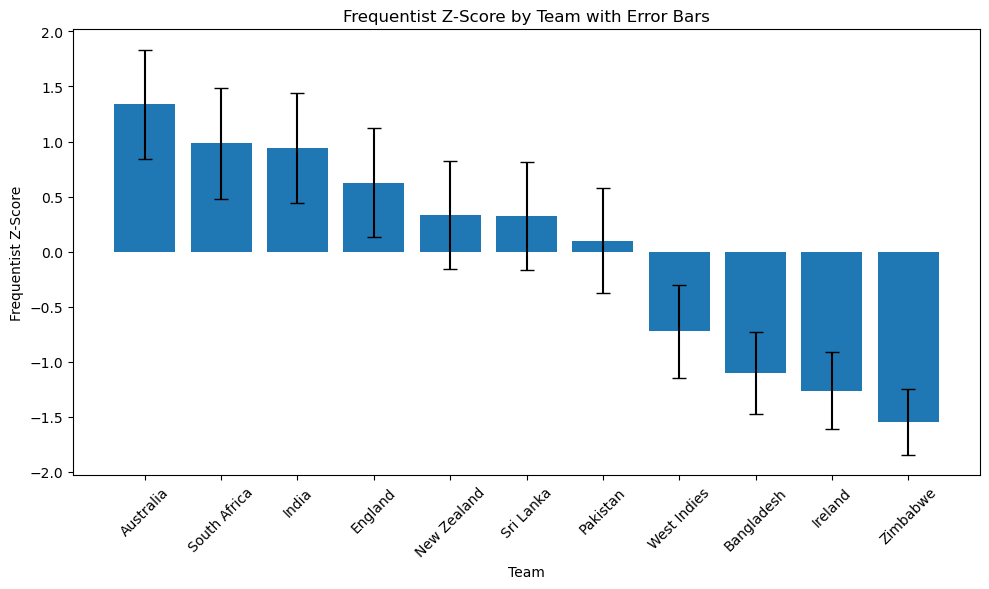

In [7]:
frequentist_summary_chart, ax = plt.subplots(figsize=(10, 6))

ax.bar(summary_frequentist['Team_x'], summary_frequentist['freqentist_z_score'], yerr=summary_frequentist['std_dev'], capsize=5)
ax.set_xlabel('Team')
ax.set_ylabel('Frequentist Z-Score')
ax.set_title('Frequentist Z-Score by Team with Error Bars')
ax.set_xticklabels(summary_frequentist['Team_x'], rotation=45)
plt.tight_layout()

plt.show()

By just taking the mean of win percentage we can see we can ranks the teams ability as:
1. Australia  
2. South Africa  
3. India  
4. England  
5. New Zealand  
6. Sri Lanka  
7. Pakistan  
8. West Indies  
9. Bangladesh  
10. Ireland  
11. Zimbabwe  


## Bayesian 1pl Rasch model.
Next, we use a Bayesian model approach for the same data. We use a rash 1-parameter logistic (1pl) model which uses ability and difficulty parameters to model outcomes.  
$$ Pr(out=1) = \frac{\exp(\alpha_i - \beta_j + \delta)}{1 + \exp(\alpha_i - \beta_j + \delta)} $$

Our approach is adapted from the Item Response Models Section of the [MC-stan guide](https://mc-stan.org/docs/2_20/stan-users-guide/item-response-models-section.html) and our model is specified as follows:

$$ \text{delta} \quad or \quad \delta \sim N(0.75,1) $$
$$ \text{ability}_i \quad or \quad \alpha_i \sim \text{Normal}(0, 1) \quad \text{for} \; i = 1, \ldots, N_{\text{teams}}  $$
$$  \text{difficulty}_j \quad or \quad \beta_j \sim \text{Normal}(0, 1) \quad \text{for} \; j = 1, \ldots, N_{\text{difficulty}}$$

$$ \text{logit}_p = \alpha_i - \beta_j + \delta $$

$$  \text{out}_n \sim \text{Binomial}(N, \text{logit}_p) $$

In [8]:
with pm.Model() as model:
    # Priors for team abilities
    n_pairs = len(cross_join_df2)
    N_teams = len(teams)
    N_difficulty = len(teams)
    team_ix = cross_join_df2['Team_x_factor']
    difficulty_ix = cross_join_df2['Team_y_factor']
    num_matchups = cross_join_df2['num_matchups']
    outcomes = cross_join_df2['wins']

    delta = pm.Normal('delta',mu=0.75,sigma=1)
    ability = pm.Normal('ability',mu=0,sigma = 1, shape = N_teams)
    difficulty = pm.Normal('difficulty',mu=0,sigma = 1, shape = N_difficulty)

    logit_p = ability[team_ix] - difficulty[difficulty_ix] + delta

    out = pm.Binomial('out',n=num_matchups,logit_p = logit_p,observed=outcomes)
    trace_1pl_2 = pm.sample(2000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, ability, difficulty]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


In [9]:
s1_1pl_2 = az.summary(trace_1pl_2,hdi_prob=0.95).reset_index()
s1_1pl_2['team_index'] = s1_1pl_2['index'].apply(extract_digit)
s1_1pl_2['team_name']  = s1_1pl_2['team_index'].map(reversed_dict)
s1_1pl_2

,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,team_index,team_name
0,delta,-0.228,0.399,-0.989,0.571,0.010,0.007,1550.0,1943.0,1.0,None,NaN
1,ability[0],1.110,0.330,0.474,1.750,0.008,0.005,1822.0,2836.0,1.0,0,Australia
2,ability[1],-1.167,0.382,-1.946,-0.452,0.008,0.005,2519.0,3955.0,1.0,1,Bangladesh
3,ability[2],0.614,0.325,0.010,1.282,0.008,0.005,1858.0,2996.0,1.0,2,England
4,ability[3],0.766,0.331,0.157,1.442,0.008,0.005,1877.0,2635.0,1.0,3,India
5,ability[4],-0.962,0.694,-2.348,0.365,0.009,0.007,6252.0,5817.0,1.0,4,Ireland
6,ability[5],0.246,0.341,-0.403,0.932,0.008,0.005,2069.0,3108.0,1.0,5,New Zealand
7,ability[6],0.083,0.342,-0.571,0.754,0.008,0.005,2033.0,3153.0,1.0,6,Pakistan
8,ability[7],0.780,0.330,0.103,1.400,0.008,0.005,1898.0,2832.0,1.0,7,South Africa
9,ability[8],0.126,0.339,-0.579,0.751,0.008,0.005,2003.0,3064.0,1.0,8,Sri Lanka


### Ability Summary

In [10]:
ability_1pl_1 = s1_1pl_2[s1_1pl_2['index'].str.contains('ability') & ~s1_1pl_2['index'].str.contains('sigma') ].sort_values('mean',ascending=False)
ability_1pl_1

,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,team_index,team_name
1,ability[0],1.110,0.330,0.474,1.750,0.008,0.005,1822.0,2836.0,1.0,0,Australia
8,ability[7],0.780,0.330,0.103,1.400,0.008,0.005,1898.0,2832.0,1.0,7,South Africa
4,ability[3],0.766,0.331,0.157,1.442,0.008,0.005,1877.0,2635.0,1.0,3,India
3,ability[2],0.614,0.325,0.010,1.282,0.008,0.005,1858.0,2996.0,1.0,2,England
6,ability[5],0.246,0.341,-0.403,0.932,0.008,0.005,2069.0,3108.0,1.0,5,New Zealand
9,ability[8],0.126,0.339,-0.579,0.751,0.008,0.005,2003.0,3064.0,1.0,8,Sri Lanka
7,ability[6],0.083,0.342,-0.571,0.754,0.008,0.005,2033.0,3153.0,1.0,6,Pakistan
10,ability[9],-0.625,0.352,-1.362,0.034,0.008,0.005,2176.0,3311.0,1.0,9,West Indies
5,ability[4],-0.962,0.694,-2.348,0.365,0.009,0.007,6252.0,5817.0,1.0,4,Ireland
2,ability[1],-1.167,0.382,-1.946,-0.452,0.008,0.005,2519.0,3955.0,1.0,1,Bangladesh


We can see that the teams ability can be ranked in the following order:
1. Australia
2. South Africa
3. India
4. England
5. New Zealand
6. Sri Lanka
7. Pakistan
8. West Indies
9. Ireland
10. Bangladesh
11. Zimbabwe


### Difficulty Summary

In [11]:
difficulty_1pl_2 = s1_1pl_2[s1_1pl_2['index'].str.contains('difficulty') & ~s1_1pl_2['index'].str.contains('sigma') ].sort_values('mean',ascending=False)
difficulty_1pl_2

,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,team_index,team_name
15,difficulty[3],1.282,0.334,0.622,1.910,0.009,0.006,1470.0,2858.0,1.0,3,India
12,difficulty[0],1.130,0.334,0.480,1.770,0.009,0.006,1420.0,2760.0,1.0,0,Australia
19,difficulty[7],0.831,0.333,0.163,1.461,0.009,0.006,1524.0,3124.0,1.0,7,South Africa
14,difficulty[2],0.818,0.326,0.182,1.433,0.008,0.006,1521.0,2836.0,1.0,2,England
17,difficulty[5],0.487,0.336,-0.196,1.114,0.009,0.006,1548.0,2775.0,1.0,5,New Zealand
20,difficulty[8],0.422,0.333,-0.244,1.038,0.009,0.006,1414.0,2863.0,1.0,8,Sri Lanka
18,difficulty[6],0.347,0.335,-0.295,1.001,0.009,0.006,1420.0,3034.0,1.0,6,Pakistan
21,difficulty[9],-0.020,0.337,-0.643,0.657,0.009,0.006,1444.0,3044.0,1.0,9,West Indies
13,difficulty[1],-1.092,0.359,-1.791,-0.400,0.008,0.006,1913.0,3614.0,1.0,1,Bangladesh
16,difficulty[4],-1.310,0.695,-2.711,0.026,0.009,0.007,5821.0,5748.0,1.0,4,Ireland


Next we can look at which team is the most difficult to face. Our model tells us that India is the model difficult team to face.
We can order team inte

1.	India
2.	Australia
3.	South Africa
4.	England
5.	New Zealand
6.	Sri Lanka
7.	Pakistan
8.	West Indies
9.	Bangladesh
10.	Ireland
11.	Zimbabwe


### Compare Difficulty and Ability

In [12]:
ability_difficulty_1pl_1 = pd.merge(ability_1pl_1[['mean','team_name','hdi_2.5%','hdi_97.5%']],
                                    difficulty_1pl_2[['mean','team_name','hdi_2.5%','hdi_97.5%']],
                                    on='team_name',how='inner',suffixes=('_ability', '_difficulty'))

In [13]:
ability_difficulty_1pl_1

,mean_ability,team_name,hdi_2.5%_ability,hdi_97.5%_ability,mean_difficulty,hdi_2.5%_difficulty,hdi_97.5%_difficulty
0,1.110,Australia,0.474,1.750,1.130,0.480,1.770
1,0.780,South Africa,0.103,1.400,0.831,0.163,1.461
2,0.766,India,0.157,1.442,1.282,0.622,1.910
3,0.614,England,0.010,1.282,0.818,0.182,1.433
4,0.246,New Zealand,-0.403,0.932,0.487,-0.196,1.114
5,0.126,Sri Lanka,-0.579,0.751,0.422,-0.244,1.038
6,0.083,Pakistan,-0.571,0.754,0.347,-0.295,1.001
7,-0.625,West Indies,-1.362,0.034,-0.020,-0.643,0.657
8,-0.962,Ireland,-2.348,0.365,-1.310,-2.711,0.026
9,-1.167,Bangladesh,-1.946,-0.452,-1.092,-1.791,-0.400


/tmp/ipykernel_50653/2040723990.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  difficulty_ability_plot_1pl.show()


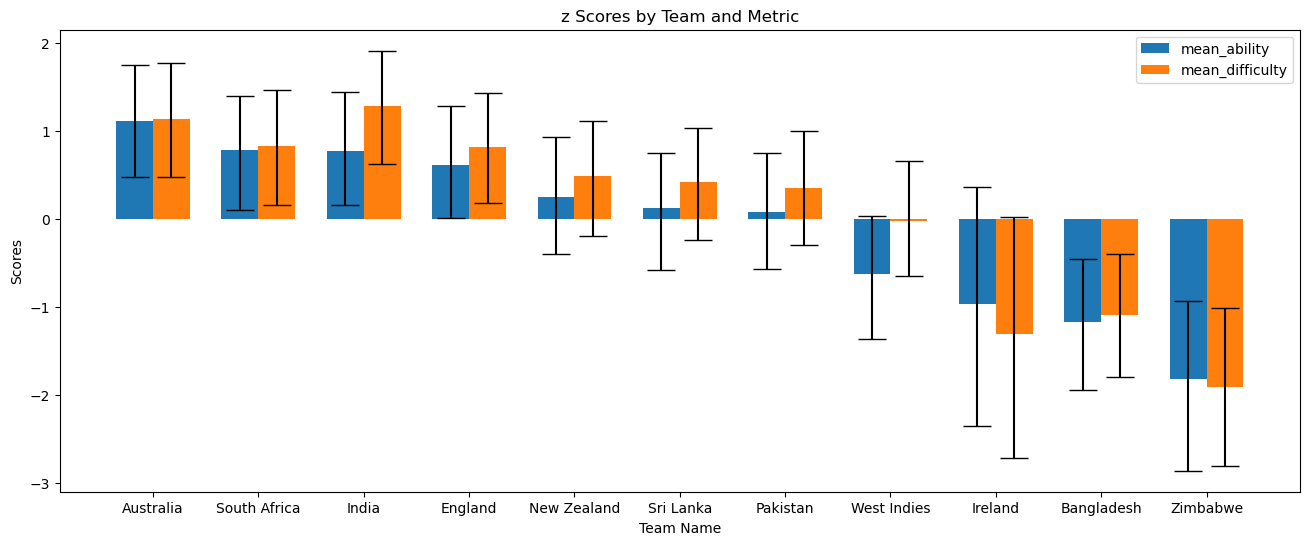

In [14]:
ability_difficulty_1pl_1 = pd.merge(ability_1pl_1[['mean','team_name','hdi_2.5%','hdi_97.5%']],difficulty_1pl_2[['mean','team_name','hdi_2.5%','hdi_97.5%']],on='team_name',how='inner',suffixes=('_ability', '_difficulty'))

error_bars_ability = [ability_difficulty_1pl_1['mean_ability'] - ability_difficulty_1pl_1['hdi_2.5%_ability'], ability_difficulty_1pl_1['hdi_97.5%_ability'] - ability_difficulty_1pl_1['mean_ability']]
error_bars_difficulty = [ability_difficulty_1pl_1['mean_difficulty'] - ability_difficulty_1pl_1['hdi_2.5%_difficulty'], ability_difficulty_1pl_1['hdi_97.5%_difficulty'] - ability_difficulty_1pl_1['mean_difficulty']]

# Set the positions and width for the bars
positions = np.arange(len(ability_difficulty_1pl_1['team_name']))
width = 0.35

# Plotting the bars
fig, ax = plt.subplots(figsize=(16, 6)) # Increase width here
bar1 = ax.bar(positions - width/2, ability_difficulty_1pl_1['mean_ability'], width,yerr=error_bars_ability, capsize=10, label='mean_ability')
bar2 = ax.bar(positions + width/2, ability_difficulty_1pl_1['mean_difficulty'],width,yerr=error_bars_difficulty, capsize=10,  label='mean_difficulty')
# bar
# Adding labels, title, and legend
ax.set_xlabel('Team Name')
ax.set_ylabel('Scores')
ax.set_title('z Scores by Team and Metric')
ax.set_xticks(positions)
ax.set_xticklabels(ability_difficulty_1pl_1['team_name'])
ax.legend()

# Store the figure in a variable
difficulty_ability_plot_1pl = fig
# Later in the code, you can render the stored plot
difficulty_ability_plot_1pl.show()

* We can see that ability and difficulty are closely related, however, it does not mean that there is a one-to-one correlation. The most difficult team is India, however, in terms of ability, India is third.
* For the bottom performers and the top performers our 95% HPD credible sets do not contain 0 indicating that we can be quite certain that these teams are underperforming or overperforming. however for the teams in the middle, the HPD interval contains 0, so we cannot say for certain if these teams are above average or below average.
* Apart from looking at the mean, we can also compare the HPD intervals for all the teams to gauge how one compares to the others. For example
  * If we compare the ability of West Indies with the ability of Australia, their HPD intervals don't overlap, we can be quite certain that Australia is a better team than West Indies.
  * If we compare the ability of Pakistan with Srilanka, because the HPD intervals have a high degree of overall we have a high degree of uncertainty about our conclusions regarding which team is better even though Sri Lanka has a higher mean ability.

We see that the mean we get from the frequentist approach matches closely with what we observe using the Bayesian 1 pl model.

## Bayesian 2pl Model
We add to a 1pl model by adding hierarchy and a discrimination term.
The probability of an outcome is modeled by:

$$ Pr(out=1) = \frac{\exp(\gamma_j * (\alpha_i - (\beta_j+\delta)))}{1 + \exp(\gamma_j * (\alpha_i - (\beta_j + \delta)))} $$

The discrimination terms are:
$$ \text{standard\ deviation\ of\ discrimination} \quad or \quad \sigma_{\gamma} \sim \text{HalfCauchy}(0, 3) $$
$$ \text{discrimination} \quad or \quad \gamma_j \sim LogNormal(0,\sigma_\gamma)$$

We define the following distribution to model a team's ability:
$$ \text{ability} \quad or \quad \alpha \sim Normal(0,1)$$

To model Opponent Difficulty we define the following distributions:
We recenter difficulty in avoiding fit issues:
<!-- $$ \text{mean\ of\ difficulty} \quad or \quad \mu_{\beta} \sim \text{studentT}(3,0,5) $$ -->
$$ \text{mean\ question\ difficulty} \quad or \quad \delta \sim \text{Cauchy}(0,5)$$
$$ \text{standard\ deviation\ of\ difficulty} \quad or \quad \sigma_{\beta} \sim \text{HalfCauchy}(0,5) $$
$$ \text{difficulty} \quad or \quad \beta \sim Normal(0,\sigma_{\beta})$$

The outcome is defined as:
$$ \text{logit}_p = \gamma_j * (\alpha_i - (\beta_j + \delta)) $$
$$  \text{out}_n \sim \text{Binomial}(N, \text{logit}_p) $$


In [15]:
rng = np.random.default_rng(1)
with pm.Model() as model:
    # Priors for team abilities
    n_pairs = len(cross_join_df2)
    N_teams = len(teams)
    N_difficulty = len(teams)
    team_ix = cross_join_df2['Team_x_factor']
    difficulty_ix = cross_join_df2['Team_y_factor']
    num_matchups = cross_join_df2['num_matchups']
    outcomes = cross_join_df2['wins']

    a_difficulty = pm.StudentT('a_difficulty',nu=3, mu=0, sigma=5)
    sigma_discrimination = pm.HalfCauchy('sigma_discrimination', beta=3) # sigma_gamma ~ cauchy(0, 5);
    # sigma_ability = pm.HalfCauchy('sigma_ability', beta=5)
    sigma_difficulty = pm.HalfCauchy('sigma_difficulty', beta=5) #  sigma_beta ~ cauchy(0, 5);

    discrimination = pm.LogNormal('discrimination', mu=0, sigma=sigma_discrimination, shape=N_difficulty) # gamma ~ lognormal(0, sigma_gamma);
    ability = pm.Normal('ability', mu=0, sigma=1, shape=N_teams) # alpha ~ std_normal();
    difficulty = pm.Normal('difficulty', mu=0, sigma=sigma_difficulty, shape=N_difficulty) # beta ~ normal(0, sigma_beta);

    mu_beta =  pm.Cauchy('mu_beta', alpha=0, beta=5) # mu_beta ~ cauchy(0, 5);
    logit_p = discrimination[difficulty_ix] * (ability[team_ix] - (difficulty[difficulty_ix] + mu_beta))

    out = pm.Binomial('out',n=num_matchups, logit_p=logit_p, observed=outcomes)
    trace_2pl_2 = pm.sample(2000, tune=1000, return_inferencedata=True,random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_difficulty, sigma_discrimination, sigma_difficulty, discrimination, ability, difficulty, mu_beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


### Arviz Summary

In [16]:
s1_2pl_2 = az.summary(trace_2pl_2,hdi_prob=0.95).reset_index()
s1_2pl_2['team_index'] = s1_2pl_2['index'].apply(extract_digit)
s1_2pl_2['team_name']  = s1_2pl_2['team_index'].map(reversed_dict)
s1_2pl_2

,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,team_index,team_name
0,a_difficulty,-0.125,9.018,-16.607,15.330,0.241,0.277,5247.0,2277.0,1.00,None,NaN
1,ability[0],1.196,0.347,0.521,1.871,0.008,0.005,2053.0,3441.0,1.00,0,Australia
2,ability[1],-1.092,0.402,-1.944,-0.351,0.008,0.005,2721.0,3992.0,1.00,1,Bangladesh
3,ability[2],0.714,0.340,0.002,1.339,0.008,0.005,1907.0,2946.0,1.00,2,England
4,ability[3],0.860,0.341,0.200,1.524,0.008,0.005,2057.0,3298.0,1.00,3,India
5,ability[4],-0.904,0.726,-2.291,0.541,0.009,0.007,5951.0,5309.0,1.00,4,Ireland
6,ability[5],0.353,0.351,-0.341,1.036,0.008,0.005,2094.0,3544.0,1.00,5,New Zealand
7,ability[6],0.171,0.353,-0.524,0.854,0.008,0.005,2157.0,3477.0,1.00,6,Pakistan
8,ability[7],0.877,0.347,0.184,1.549,0.008,0.006,1981.0,3376.0,1.00,7,South Africa
9,ability[8],0.235,0.350,-0.459,0.908,0.008,0.005,2160.0,3584.0,1.00,8,Sri Lanka


### Ability Summary

In [17]:
ability_2pl_1 = s1_2pl_2[s1_2pl_2['index'].str.contains('ability') & ~s1_2pl_2['index'].str.contains('sigma') ].sort_values('mean',ascending=False)
ability_2pl_1

,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,team_index,team_name
1,ability[0],1.196,0.347,0.521,1.871,0.008,0.005,2053.0,3441.0,1.0,0,Australia
8,ability[7],0.877,0.347,0.184,1.549,0.008,0.006,1981.0,3376.0,1.0,7,South Africa
4,ability[3],0.860,0.341,0.200,1.524,0.008,0.005,2057.0,3298.0,1.0,3,India
3,ability[2],0.714,0.340,0.002,1.339,0.008,0.005,1907.0,2946.0,1.0,2,England
6,ability[5],0.353,0.351,-0.341,1.036,0.008,0.005,2094.0,3544.0,1.0,5,New Zealand
9,ability[8],0.235,0.350,-0.459,0.908,0.008,0.005,2160.0,3584.0,1.0,8,Sri Lanka
7,ability[6],0.171,0.353,-0.524,0.854,0.008,0.005,2157.0,3477.0,1.0,6,Pakistan
10,ability[9],-0.565,0.368,-1.258,0.198,0.008,0.005,2377.0,3528.0,1.0,9,West Indies
5,ability[4],-0.904,0.726,-2.291,0.541,0.009,0.007,5951.0,5309.0,1.0,4,Ireland
2,ability[1],-1.092,0.402,-1.944,-0.351,0.008,0.005,2721.0,3992.0,1.0,1,Bangladesh


We can see that the team's ability can be ranked in the following order:  
1.	Australia  
2.	South Africa  
3.	India  
4.	England   
5.	New Zealand  
6.	Sri Lanka  
7.	Pakistan  
8.	West Indies  
9.	Ireland  
10.	Bangladesh  
11.	Zimbabwe  

### Difficulty Summary

In [18]:
difficulty_2pl_2 = s1_2pl_2[s1_2pl_2['index'].str.contains('difficulty') & ~s1_2pl_2['index'].str.contains('sigma') &  ~s1_2pl_2['index'].str.contains('a_difficulty') ].sort_values('mean',ascending=False)
difficulty_2pl_2

,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,team_index,team_name
15,difficulty[3],1.232,0.470,0.251,2.111,0.011,0.008,1758.0,2523.0,1.0,3,India
12,difficulty[0],1.103,0.468,0.183,2.060,0.011,0.008,1816.0,2708.0,1.0,0,Australia
14,difficulty[2],0.830,0.462,-0.045,1.795,0.011,0.008,1662.0,2402.0,1.0,2,England
19,difficulty[7],0.748,0.451,-0.117,1.677,0.011,0.008,1649.0,2337.0,1.0,7,South Africa
17,difficulty[5],0.430,0.446,-0.425,1.350,0.011,0.008,1639.0,2125.0,1.0,5,New Zealand
20,difficulty[8],0.354,0.441,-0.579,1.196,0.011,0.008,1684.0,2463.0,1.0,8,Sri Lanka
18,difficulty[6],0.328,0.456,-0.541,1.291,0.011,0.008,1678.0,2439.0,1.0,6,Pakistan
21,difficulty[9],-0.080,0.448,-0.937,0.872,0.011,0.008,1695.0,2366.0,1.0,9,West Indies
13,difficulty[1],-1.245,0.504,-2.282,-0.286,0.012,0.008,1846.0,2389.0,1.0,1,Bangladesh
16,difficulty[4],-1.615,0.874,-3.409,0.027,0.013,0.010,4477.0,3957.0,1.0,4,Ireland


The difficulty of the opposition can be ranked as follows
1.	India
2.	Australia
3.	England
4.	South Africa
5.	New Zealand
6.	Sri Lanka
7.	Pakistan
8.	West Indies
9.	Bangladesh
10.	Ireland
11.	Zimbabwe


### Discrimination Summary

In [19]:
discrimination_2pl_2 = s1_2pl_2[s1_2pl_2['index'].str.contains('discrimination') & ~s1_2pl_2['index'].str.contains('sigma') &  ~s1_2pl_2['index'].str.contains('a_difficulty') ].sort_values('mean',ascending=False)
discrimination_2pl_2

,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,team_index,team_name
34,discrimination[8],1.097,0.193,0.790,1.535,0.004,0.003,3039.0,3079.0,1.00,8,Sri Lanka
33,discrimination[7],1.096,0.203,0.736,1.531,0.004,0.003,3051.0,3816.0,1.00,7,South Africa
30,discrimination[4],1.078,0.305,0.618,1.621,0.006,0.005,6517.0,2516.0,1.01,4,Ireland
31,discrimination[5],1.043,0.167,0.701,1.405,0.002,0.002,6968.0,3772.0,1.00,5,New Zealand
29,discrimination[3],1.038,0.176,0.698,1.421,0.002,0.002,6782.0,3732.0,1.00,3,India
36,discrimination[10],1.037,0.188,0.655,1.430,0.002,0.002,6988.0,3633.0,1.00,10,Zimbabwe
26,discrimination[0],1.014,0.173,0.662,1.386,0.002,0.002,6900.0,3484.0,1.00,0,Australia
35,discrimination[9],0.964,0.147,0.652,1.263,0.002,0.001,6778.0,3291.0,1.00,9,West Indies
27,discrimination[1],0.939,0.150,0.601,1.215,0.003,0.002,2709.0,3431.0,1.00,1,Bangladesh
28,discrimination[2],0.923,0.143,0.590,1.172,0.003,0.002,2801.0,2863.0,1.00,2,England


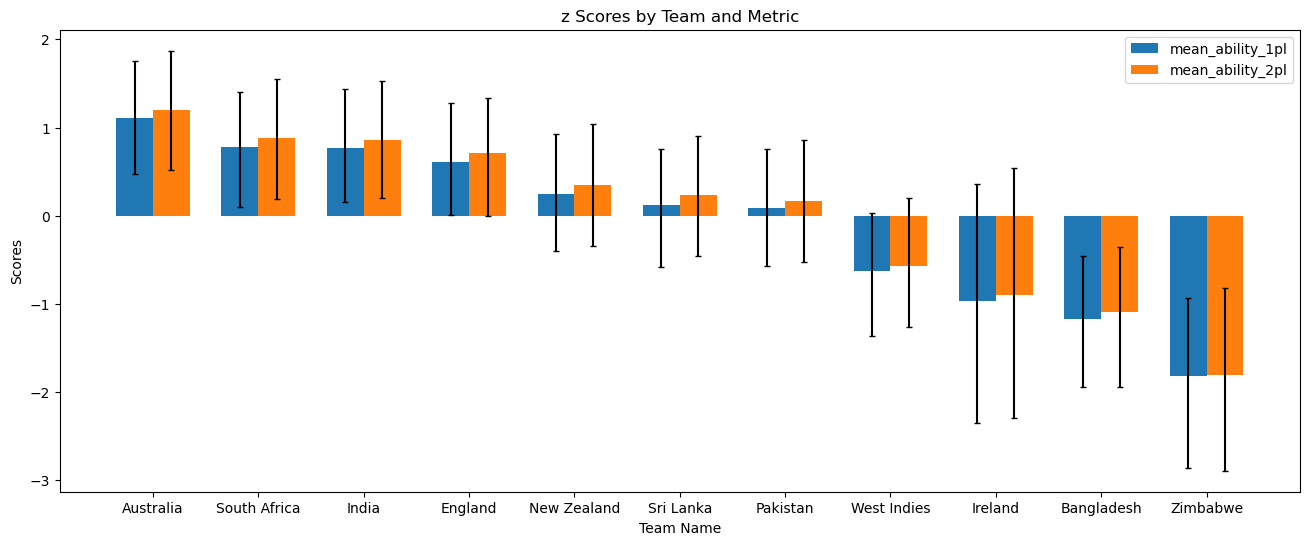

In [20]:
ability_difficulty_1pl_2pl_1 = pd.merge(ability_1pl_1[['mean','team_name','hdi_2.5%','hdi_97.5%']],ability_2pl_1[['mean','team_name','hdi_2.5%','hdi_97.5%']],on='team_name',how='inner',suffixes=('_ability_1pl', '_ability_2pl'))
error_bars_ability_1pl1 = [ability_difficulty_1pl_2pl_1['mean_ability_1pl'] - ability_difficulty_1pl_2pl_1['hdi_2.5%_ability_1pl'], ability_difficulty_1pl_2pl_1['hdi_97.5%_ability_1pl'] - ability_difficulty_1pl_2pl_1['mean_ability_1pl']]
error_bars_ability_2pl1 = [ability_difficulty_1pl_2pl_1['mean_ability_2pl'] - ability_difficulty_1pl_2pl_1['hdi_2.5%_ability_2pl'], ability_difficulty_1pl_2pl_1['hdi_97.5%_ability_2pl'] - ability_difficulty_1pl_2pl_1['mean_ability_2pl']]

# Set the positions and width for the bars
positions = np.arange(len(ability_difficulty_1pl_2pl_1['team_name']))
width = 0.35

# Plotting the bars
fig, ax = plt.subplots(figsize=(16, 6)) # Increase width here
bar1 = ax.bar(positions - width/2, ability_difficulty_1pl_2pl_1['mean_ability_1pl'], width,yerr=error_bars_ability_1pl1, capsize=2, label='mean_ability_1pl')
bar2 = ax.bar(positions + width/2, ability_difficulty_1pl_2pl_1['mean_ability_2pl'],width,yerr=error_bars_ability_2pl1, capsize=2,  label='mean_ability_2pl')
# bar
# Adding labels, title, and legend
ax.set_xlabel('Team Name')
ax.set_ylabel('Scores')
ax.set_title('z Scores by Team and Metric')
ax.set_xticks(positions)
ax.set_xticklabels(ability_difficulty_1pl_2pl_1['team_name'])
ax.legend()

/tmp/ipykernel_50653/1881396008.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  difficulty_ability_plot_2pl_vs_1pl.show()


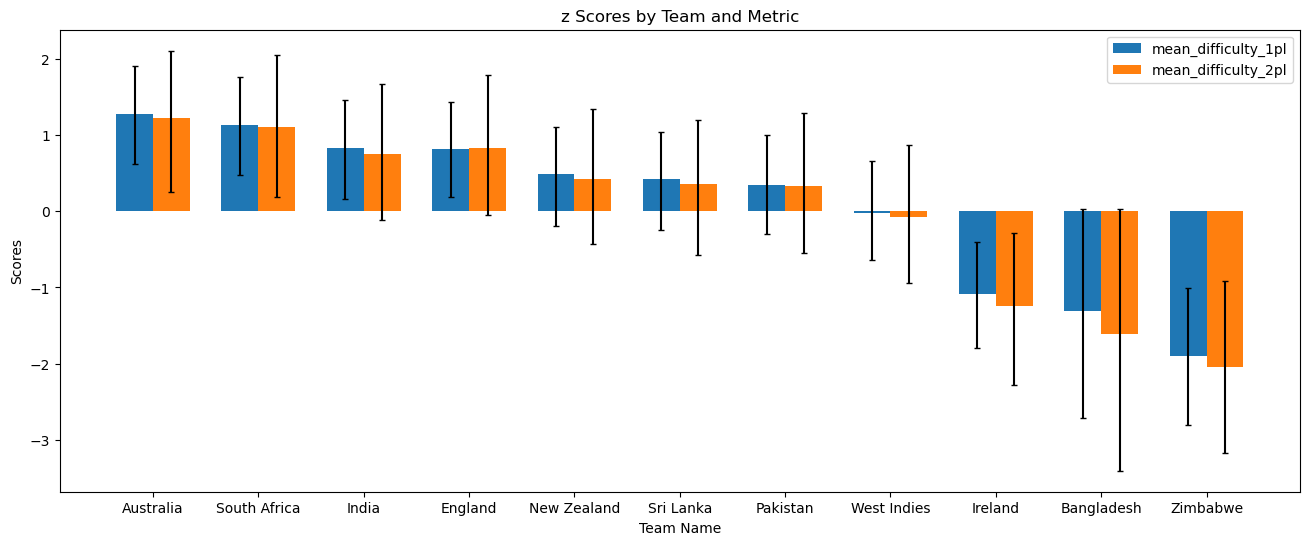

In [21]:
ability_difficulty_1pl_2pl_2 = pd.merge(difficulty_1pl_2[['mean','team_name','hdi_2.5%','hdi_97.5%']],difficulty_2pl_2[['mean','team_name','hdi_2.5%','hdi_97.5%']],on='team_name',how='inner',suffixes=('_difficulty_1pl', '_difficulty_2pl'))

# Calculate error bars
error_bars_difficulty_1pl1 = [ability_difficulty_1pl_2pl_2['mean_difficulty_1pl'] - ability_difficulty_1pl_2pl_2['hdi_2.5%_difficulty_1pl'], ability_difficulty_1pl_2pl_2['hdi_97.5%_difficulty_1pl'] - ability_difficulty_1pl_2pl_2['mean_difficulty_1pl']]
error_bars_difficulty_2pl1 = [ability_difficulty_1pl_2pl_2['mean_difficulty_2pl'] - ability_difficulty_1pl_2pl_2['hdi_2.5%_difficulty_2pl'], ability_difficulty_1pl_2pl_2['hdi_97.5%_difficulty_2pl'] - ability_difficulty_1pl_2pl_2['mean_difficulty_2pl']]

# Set the positions and width for the bars
positions = np.arange(len(ability_difficulty_1pl_2pl_2['team_name']))
width = 0.35

# Plotting the bars
fig, ax = plt.subplots(figsize=(16, 6))  # Increase width here
bar1 = ax.bar(positions - width/2, ability_difficulty_1pl_2pl_2['mean_difficulty_1pl'], width, yerr=error_bars_difficulty_1pl1, capsize=2, label='mean_difficulty_1pl')
bar2 = ax.bar(positions + width/2, ability_difficulty_1pl_2pl_2['mean_difficulty_2pl'], width, yerr=error_bars_difficulty_2pl1, capsize=2, label='mean_difficulty_2pl')

# Adding labels, title, and legend
ax.set_xlabel('Team Name')
ax.set_ylabel('Scores')
ax.set_title('z Scores by Team and Metric')
ax.set_xticks(positions)
ax.set_xticklabels(ability_difficulty_1pl_2pl_1['team_name'])
ax.legend()

# Store the figure in a variable
difficulty_ability_plot_2pl_vs_1pl = fig
# Later in the code, you can render the stored plot
difficulty_ability_plot_2pl_vs_1pl.show()

### Plot Discrimination

/tmp/ipykernel_50653/2192592902.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  discrimination_2pl.show()


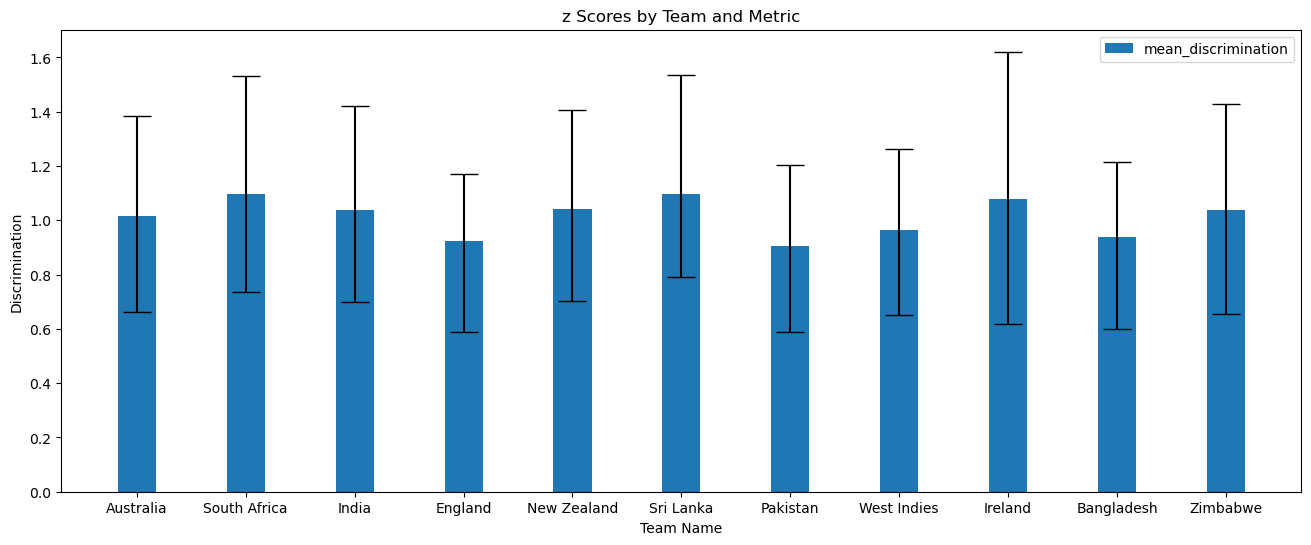

In [22]:
# Merge data frames
ability_difficulty_discrimination = pd.merge(
    pd.merge(ability_2pl_1[['mean','team_name','hdi_2.5%','hdi_97.5%']],
             difficulty_2pl_2[['mean','team_name','hdi_2.5%','hdi_97.5%']],
             on='team_name',
             how='inner',
             suffixes=('_ability', '_difficulty')),
    discrimination_2pl_2[['mean','team_name','hdi_2.5%','hdi_97.5%']],
    on='team_name',
    how='inner'
).rename(columns={'mean': 'mean_discrimination', 'hdi_2.5%': 'hdi_2.5%_discrimination', 'hdi_97.5%': 'hdi_97.5%_discrimination'})

# Calculate error bars
error_bars_ability = [
    ability_difficulty_discrimination['mean_ability'] - ability_difficulty_discrimination['hdi_2.5%_ability'],
    ability_difficulty_discrimination['hdi_97.5%_ability'] - ability_difficulty_discrimination['mean_ability']
]
error_bars_difficulty = [
    ability_difficulty_discrimination['mean_difficulty'] - ability_difficulty_discrimination['hdi_2.5%_difficulty'],
    ability_difficulty_discrimination['hdi_97.5%_difficulty'] - ability_difficulty_discrimination['mean_difficulty']
]
error_bars_discrimination = [
    ability_difficulty_discrimination['mean_discrimination'] - ability_difficulty_discrimination['hdi_2.5%_discrimination'],
    ability_difficulty_discrimination['hdi_97.5%_discrimination'] - ability_difficulty_discrimination['mean_discrimination']
]

# Set the positions and width for the bars
positions = np.arange(len(ability_difficulty_discrimination['team_name']))
width = 0.35

# Plotting the bars
fig, ax = plt.subplots(figsize=(16, 6))  # Increase width here
# bar1 = ax.bar(
#     positions - width/2,
#     ability_difficulty_discrimination['mean_ability'],
#     width,
#     yerr=error_bars_ability,
#     capsize=10,
#     label='mean_ability'
# )
# bar2 = ax.bar(
#     positions + width/2,
#     ability_difficulty_discrimination['mean_difficulty'],
#     width,
#     yerr=error_bars_difficulty,
#     capsize=10,
#     label='mean_difficulty'
# )
bar3 = ax.bar(
    positions,
    ability_difficulty_discrimination['mean_discrimination'],
    width,
    yerr=error_bars_discrimination,
    capsize=10,
    label='mean_discrimination'
)

# Adding labels, title, and legend
ax.set_xlabel('Team Name')
ax.set_ylabel('Discrimination')
ax.set_title('z Scores by Team and Metric')
ax.set_xticks(positions)
ax.set_xticklabels(ability_difficulty_discrimination['team_name'])
ax.legend()

# Store the figure in a variable
discrimination_2pl = fig
# Later in the code, you can render the stored plot
discrimination_2pl.show()

### Compare Difficulty and Ability

/tmp/ipykernel_50653/1227178939.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  difficulty_ability_plot_2pl.show()


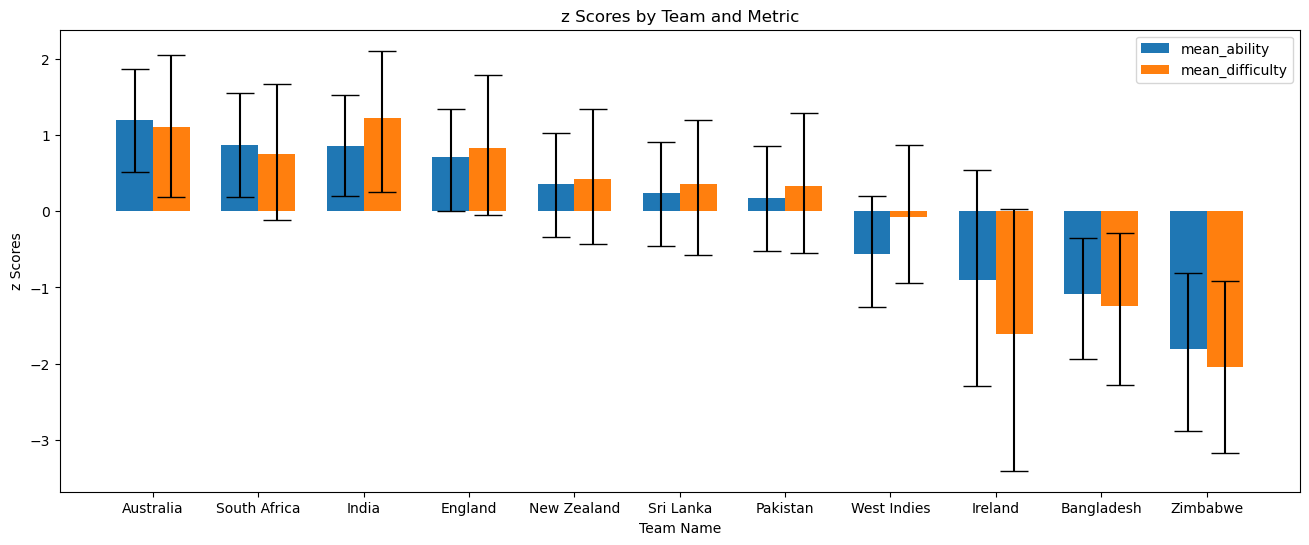

In [23]:
# Merge data frames
ability_difficulty_2pl_1 = pd.merge(
    pd.merge(ability_2pl_1[['mean','team_name','hdi_2.5%','hdi_97.5%']],
             difficulty_2pl_2[['mean','team_name','hdi_2.5%','hdi_97.5%']],
             on='team_name',
             how='inner',
             suffixes=('_ability', '_difficulty')),
    discrimination_2pl_2[['mean','team_name','hdi_2.5%','hdi_97.5%']],
    on='team_name',
    how='inner'
).rename(columns={'mean': 'mean_discrimination', 'hdi_2.5%': 'hdi_2.5%_discrimination', 'hdi_97.5%': 'hdi_97.5%_discrimination'})

# Calculate error bars
error_bars_ability = [
    ability_difficulty_2pl_1['mean_ability'] - ability_difficulty_2pl_1['hdi_2.5%_ability'],
    ability_difficulty_2pl_1['hdi_97.5%_ability'] - ability_difficulty_2pl_1['mean_ability']
]
error_bars_difficulty = [
    ability_difficulty_2pl_1['mean_difficulty'] - ability_difficulty_2pl_1['hdi_2.5%_difficulty'],
    ability_difficulty_2pl_1['hdi_97.5%_difficulty'] - ability_difficulty_2pl_1['mean_difficulty']
]
error_bars_discrimination = [
    ability_difficulty_2pl_1['mean_discrimination'] - ability_difficulty_2pl_1['hdi_2.5%_discrimination'],
    ability_difficulty_2pl_1['hdi_97.5%_discrimination'] - ability_difficulty_2pl_1['mean_discrimination']
]

# Set the positions and width for the bars
positions = np.arange(len(ability_difficulty_2pl_1['team_name']))
width = 0.35

# Plotting the bars
fig, ax = plt.subplots(figsize=(16, 6))  # Increase width here
bar1 = ax.bar(
    positions - width/2,
    ability_difficulty_2pl_1['mean_ability'],
    width,
    yerr=error_bars_ability,
    capsize=10,
    label='mean_ability'
)
bar2 = ax.bar(
    positions + width/2,
    ability_difficulty_2pl_1['mean_difficulty'],
    width,
    yerr=error_bars_difficulty,
    capsize=10,
    label='mean_difficulty'
)
# bar3 = ax.bar(
#     positions + width,
#     ability_difficulty_2pl_1['mean_discrimination'],
#     width,
#     yerr=error_bars_discrimination,
#     capsize=10,
#     label='mean_discrimination'
# )

# Adding labels, title, and legend
ax.set_xlabel('Team Name')
ax.set_ylabel('z Scores')
ax.set_title('z Scores by Team and Metric')
ax.set_xticks(positions)
ax.set_xticklabels(ability_difficulty_2pl_1['team_name'])
ax.legend()

# Store the figure in a variable
difficulty_ability_plot_2pl = fig
# Later in the code, you can render the stored plot
difficulty_ability_plot_2pl.show()


### Compare Frequentist vs Bayesian 1pl vs Bayesian 2pl

In [24]:
ability_difficulty_1pl_2 = ability_difficulty_1pl_1.add_suffix('_1pl')
ability_difficulty_freq_1pl_1 = pd.merge(ability_difficulty_1pl_2, 
                                         summary_frequentist[['Team_x','freqentist_z_score','std_dev']], 
                                         left_on='team_name_1pl', 
                                         right_on='Team_x', 
                                         suffixes=("_1pl", "_frequentist"))

ability_difficulty_2pl_2 = ability_difficulty_2pl_1.add_suffix('_2pl')
ability_difficulty_freq_1pl_1_2pl_1 = pd.merge(ability_difficulty_freq_1pl_1,
                                               ability_difficulty_2pl_2[['mean_ability_2pl', 'team_name_2pl', 
                                                                         'hdi_2.5%_ability_2pl', 'hdi_97.5%_ability_2pl', 
                                                                         'mean_difficulty_2pl', 
                                                                         'hdi_2.5%_difficulty_2pl', 'hdi_97.5%_difficulty_2pl']],
                                         left_on='team_name_1pl', 
                                         right_on='team_name_2pl', 
                                         suffixes=("", "_2pl"))

#### Plot ability
Compare ability estimate of 1pl and 2pl model and also the win percentage seen from the data.

/tmp/ipykernel_50653/2369363200.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ability_measured_by_each_model.show()


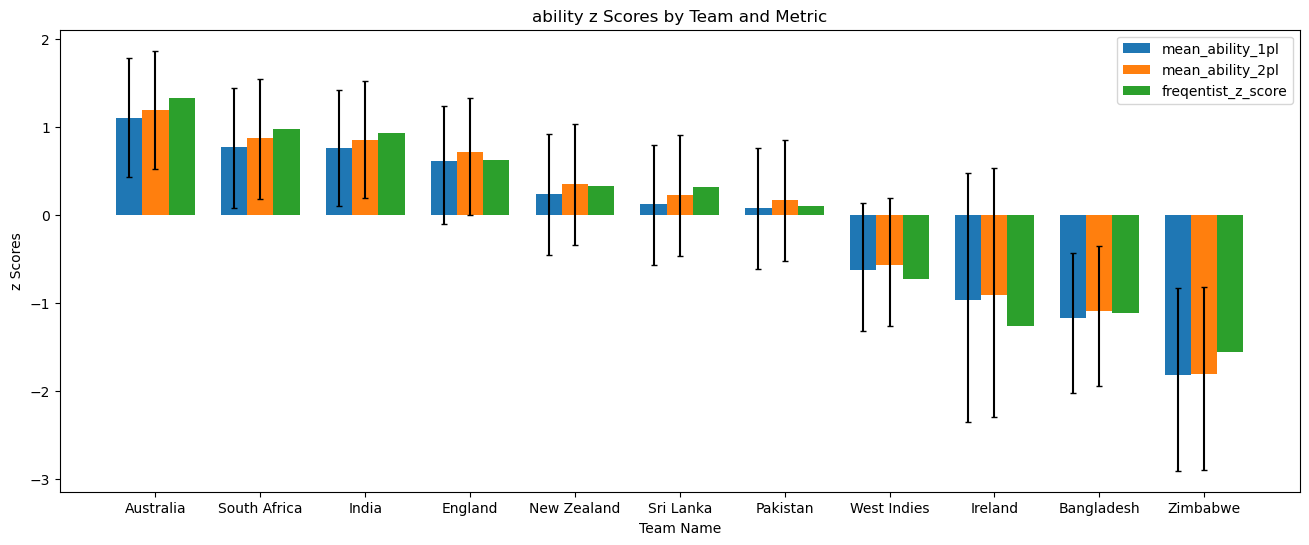

In [25]:
error_bars_ability_1pl1 = [ability_difficulty_freq_1pl_1_2pl_1['mean_ability_1pl'] - ability_difficulty_freq_1pl_1_2pl_1['hdi_2.5%_ability_1pl'], 
                           ability_difficulty_freq_1pl_1_2pl_1['hdi_97.5%_ability_1pl'] - ability_difficulty_freq_1pl_1_2pl_1['mean_ability_1pl']]
error_bars_ability_2pl1 = [ability_difficulty_freq_1pl_1_2pl_1['mean_ability_2pl'] - ability_difficulty_freq_1pl_1_2pl_1['hdi_2.5%_ability_2pl'], 
                         ability_difficulty_freq_1pl_1_2pl_1['hdi_97.5%_ability_2pl'] - ability_difficulty_freq_1pl_1_2pl_1['mean_ability_2pl']]
error_bars_frequentist = [ability_difficulty_freq_1pl_1_2pl_1['std_dev'],ability_difficulty_freq_1pl_1_2pl_1['std_dev']]
# error_bars_frequentist

# Set the positions and width for the bars
positions = np.arange(len(ability_difficulty_freq_1pl_1_2pl_1['team_name_2pl']))
width = 0.25

# Plotting the bars
fig, ax = plt.subplots(figsize=(16, 6)) # Increase width here
bar1 = ax.bar(positions - width, ability_difficulty_freq_1pl_1_2pl_1['mean_ability_1pl'], 
              width,yerr=error_bars_ability, capsize=2, label='mean_ability_1pl')
bar2 = ax.bar(positions, ability_difficulty_freq_1pl_1_2pl_1['mean_ability_2pl'],
              width,yerr=error_bars_ability_2pl1, capsize=2,  label='mean_ability_2pl')
bar3 = ax.bar(positions + width, ability_difficulty_freq_1pl_1_2pl_1['freqentist_z_score'],
              width,
              # yerr=error_bars_frequentist, 
              capsize=2,  label='freqentist_z_score')

# Adding labels, title, and legend
ax.set_xlabel('Team Name')
ax.set_ylabel('z Scores')
ax.set_title('ability z Scores by Team and Metric')
ax.set_xticks(positions)
ax.set_xticklabels(ability_difficulty_freq_1pl_1_2pl_1['team_name_2pl'])
ax.legend()

# Store the figure in a variable
ability_measured_by_each_model = fig
# Later in the code, you can render the stored plot
ability_measured_by_each_model.show()

#### Plot difficulty
compare the difficulty estimate of 1pl with 2pl model   
means are similar but 2pl model has a wider credible set

/tmp/ipykernel_50653/2797447929.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  difficulty_measured_by_each_model.show()


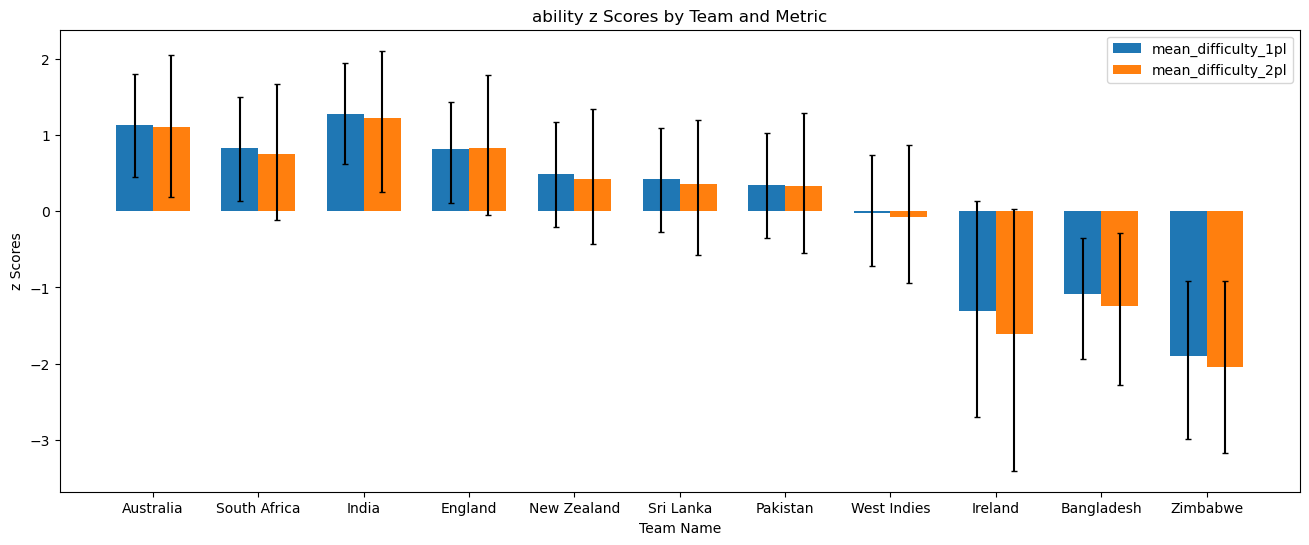

In [26]:
error_bars_ability_1pl1 = [ability_difficulty_freq_1pl_1_2pl_1['mean_difficulty_1pl'] - ability_difficulty_freq_1pl_1_2pl_1['hdi_2.5%_difficulty_1pl'], 
                           ability_difficulty_freq_1pl_1_2pl_1['hdi_97.5%_difficulty_1pl'] - ability_difficulty_freq_1pl_1_2pl_1['mean_difficulty_1pl']]
error_bars_ability_2pl1 = [ability_difficulty_freq_1pl_1_2pl_1['mean_difficulty_2pl'] - ability_difficulty_freq_1pl_1_2pl_1['hdi_2.5%_difficulty_2pl'], 
                         ability_difficulty_freq_1pl_1_2pl_1['hdi_97.5%_difficulty_2pl'] - ability_difficulty_freq_1pl_1_2pl_1['mean_difficulty_2pl']]
error_bars_frequentist = [ability_difficulty_freq_1pl_1_2pl_1['std_dev'],ability_difficulty_freq_1pl_1_2pl_1['std_dev']]
# error_bars_frequentist

# Set the positions and width for the bars
positions = np.arange(len(ability_difficulty_freq_1pl_1_2pl_1['team_name_2pl']))
width = 0.35

# Plotting the bars
fig, ax = plt.subplots(figsize=(16, 6)) # Increase width here
bar1 = ax.bar(positions - width/2, ability_difficulty_freq_1pl_1_2pl_1['mean_difficulty_1pl'], 
              width,yerr=error_bars_ability, capsize=2, label='mean_difficulty_1pl')
bar2 = ax.bar(positions + width/2, ability_difficulty_freq_1pl_1_2pl_1['mean_difficulty_2pl'],
              width,yerr=error_bars_ability_2pl1, capsize=2,  label='mean_difficulty_2pl')
# bar3 = ax.bar(positions + width, ability_difficulty_freq_1pl_1_2pl_1['freqentist_z_score'],
#               width,
#               # yerr=error_bars_frequentist, 
#               capsize=2,  label='freqentist_z_score')

# Adding labels, title, and legend
ax.set_xlabel('Team Name')
ax.set_ylabel('z Scores')
ax.set_title('ability z Scores by Team and Metric')
ax.set_xticks(positions)
ax.set_xticklabels(ability_difficulty_freq_1pl_1_2pl_1['team_name_2pl'])
ax.legend()

# Store the figure in a variable
difficulty_measured_by_each_model = fig
# Later in the code, you can render the stored plot
difficulty_measured_by_each_model.show()

# References  
* https://mc-stan.org/docs/2_20/stan-users-guide/item-response-models-section.html
* https://areding.github.io/6420-pymc/unit10/Unit10-rasch.html